In [1]:
import os, json, random, re, math, textwrap, hashlib, sys, time, gc, torch, evaluate
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
    AutoModelForCausalLM,
    TextClassificationPipeline,
    set_seed,
    BitsAndBytesConfig,
    AutoTokenizer as ClsTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict, Value
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

set_seed(42) 
torch.backends.cuda.matmul.allow_tf32 = True
device = 0 if torch.cuda.is_available() else -1
print("CUDA:", torch.cuda.is_available())

2025-10-11 18:36:25.276002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-11 18:36:25.698253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-11 18:36:26.825368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CUDA: True


In [2]:
LABELS = [
    "transfer_status",           # статус перевода
    "create_transfer",           # сделать перевод
    "block_card",                # заблокировать карту
    "unblock_card",              # разблокировать карту
    "report_lost_card",          # потеря/кража карты
    "increase_credit_limit",     # повысить кредитный лимит
    "credit_interest_rate",      # какая ставка по кредиту
    "early_loan_repayment",      # досрочное погашение кредита
    "account_balance",           # баланс по счёту/карте
    "atm_issue",                 # проблема со снятием/банкоматом
    "fee_dispute",               # спор по списанию/комиссии
    "change_phone_number",       # смена номера телефона
    "change_address",            # смена адреса
    "app_login_problem",         # не могу войти в приложение
    "statement_request",         # выписка по счёту/карте
    "exchange_rate",             # курс валют/обмен
    "cashback_info"              # кешбэк/акции по карте
]

CANNED_ANSWERS = {
    "transfer_status": "Проверю статус перевода. Уточните, пожалуйста, дату отправки, сумму и последние 4 цифры карты получателя.",
    "create_transfer": "Сейчас помогу оформить перевод. Напишите сумму, валюту и ФИО/номер карты или счёта получателя.",
    "block_card": "Срочно оформлю блокировку. Подтвердите последние 4 цифры карты и причину блокировки.",
    "unblock_card": "Для разблокировки карты нужна идентификация. Подтвердите ФИО и дату рождения, далее пришлю инструкцию.",
    "report_lost_card": "Приму заявку на утрату. Подтвердите личность — затем выпустим замену и доставим вам новую карту.",
    "increase_credit_limit": "Отправлю запрос на повышение лимита. Уточните желаемый лимит и подтверждающие документы (если есть).",
    "credit_interest_rate": "Действующая ставка зависит от типа кредита. Уточните продукт (карта/потребкредит/ипотека) и мы пришлём точные условия.",
    "early_loan_repayment": "Досрочное погашение возможно. Сообщите номер договора и сумму — рассчитаю точный остаток и график.",
    "account_balance": "Сейчас подскажу баланс. Сообщите, пожалуйста, тип продукта (дебетовая карта/счёт) и последние 4 цифры.",
    "atm_issue": "Понимаю. Укажите адрес банкомата, время операции и сумму — передам заявку в техподдержку.",
    "fee_dispute": "Разберёмся со списанием. Пришлите дату, сумму, скрин операции — откроем обращение и вернёмся с ответом.",
    "change_phone_number": "Сменим номер. Для безопасности пройдите идентификацию в приложении «Профиль → Контакты». Могу прислать пошагово.",
    "change_address": "Обновим адрес. Направьте новый адрес и подтверждающий документ (по необходимости).",
    "app_login_problem": "Помогу со входом. Скажите, какая ошибка отображается, и подтвердите, что есть доступ к привязанному номеру.",
    "statement_request": "Сформируем выписку. Уточните период и получателя (email/скачивание в PDF).",
    "exchange_rate": "Актуальный курс пришлю. Укажите валютную пару и канал (касса/онлайн) — курсы различаются.",
    "cashback_info": "Расскажу о кешбэке и акциях. Напишите категорию покупок и вашу карту."
}


In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
device_map = "auto"

GEN_MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

tok = AutoTokenizer.from_pretrained(
    GEN_MODEL_NAME,
    use_fast=True,
    trust_remote_code=True,   
)


bnb_config = BitsAndBytesConfig(load_in_8bit=True)

mdl = AutoModelForCausalLM.from_pretrained(
    GEN_MODEL_NAME,
    device_map=device_map,          
    trust_remote_code=True,
    quantization_config=bnb_config, 
    torch_dtype=torch.bfloat16      
)

def make_bad_words_ids(tokenizer, words):
    toks = [tokenizer(w, add_special_tokens=False).input_ids for w in words]
    return [t for t in toks if t]

BAD_WORDS_IDS = make_bad_words_ids(tok, [
    "пользователь","Пользователь",
    "интент","Интент",
    "класс","Класс",
    "задача","Задача",
    "по теме","По теме",
    "описание","Описание",
    "согласно инструкции","Согласно инструкции",
])

textgen = pipeline(
    "text-generation",
    model=mdl,
    tokenizer=tok,
    max_new_tokens=160,
    do_sample=True, temperature=0.7, top_p=0.9, top_k=50,
    repetition_penalty=1.1, no_repeat_ngram_size=4,
    bad_words_ids=BAD_WORDS_IDS,
    eos_token_id=tok.eos_token_id, pad_token_id=tok.eos_token_id,
    return_full_text=False,  
)

def to_chat(msgs): 
    return tok.apply_chat_template(
        msgs,
        tokenize=False,
        add_generation_prompt=True
    )


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [4]:
INTENT_SPEC = {
    "transfer_status": "вежливый пользователь интересуется, дошёл ли перевод, упоминая сумму, дату или время отправки",
    "create_transfer": "пользователь просит сделать перевод, указывает сумму и карту/счёт получателя",
    "block_card": "пользователь встревожен и просит срочно заблокировать карту из-за потери или подозрительной операции",
    "unblock_card": "пользователь хочет разблокировать карту, которую раньше блокировал, упоминает причину",
    "report_lost_card": "пользователь сообщает о потере карты и просит перевыпуск, говорит с тревогой или растерянностью",
    "increase_credit_limit": "пользователь хочет увеличить кредитный лимит, упоминает желаемую сумму или доход",
    "credit_interest_rate": "пользователь спрашивает, какая процентная ставка по кредиту, сравнивает варианты",
    "early_loan_repayment": "пользователь уточняет условия досрочного погашения кредита, спрашивает о комиссии или расчёте",
    "account_balance": "пользователь спрашивает текущий баланс счёта или карты, называет тип карты или банк",
    "atm_issue": "раздражённый пользователь жалуется, что банкомат не выдал деньги, съел карту или завис",
    "fee_dispute": "пользователь спорит со списанием, упоминает конкретную сумму и время операции",
    "change_phone_number": "пользователь просит сменить номер телефона в профиле, говорит спокойно, уточняет процесс",
    "change_address": "пользователь сообщает о переезде и просит изменить адрес проживания или доставки",
    "app_login_problem": "пользователь жалуется, что не может войти в банковское приложение, описывает ошибку",
    "statement_request": "пользователь просит выписку по счёту за определённый период, уточняет способ получения",
    "exchange_rate": "пользователь спрашивает курс валют, указывает валютную пару, например доллар/рубль",
    "cashback_info": "пользователь интересуется кешбэком или акциями по карте, спрашивает о категориях покупок"
}

def build_prompt(label: str) -> str:
    return textwrap.dedent(f"""
    Сгенерируй короткий диалог на чистом русском языке между клиентом банка (user) и поддержкой (assistant).

    Правила:
    - Говори естественно, с лёгкими эмоциями и вариативными фразами.
    - Реплики клиента — только от первого лица ("я", "мне", "мой"), без слов «пользователь», «интент», «класс», «по теме».
    - Диалог должен быть реалистичным, вежливым, без шаблонных повторов.
    - 3–6 реплик в формате "user:" и "assistant:".
    - Последняя строка — обязательно "user: ..." с конкретным вопросом по теме.
    - Не вставляй английские, украинские или служебные слова.
    - Если нужно — добавляй бытовые детали (день недели, сумма, настроение и т.п.).

    Тема диалога: {INTENT_SPEC[label]}

    Пример стиля:
    user: Добрый день! Я вчера перевёл 10 000 ₽ другу, но деньги пока не дошли.
    assistant: Сейчас проверю. Укажите, пожалуйста, время перевода и последние 4 цифры карты.
    user: Отправлял около 18:30. Можно узнать, дошёл ли перевод?

    Сгенерируй только сам диалог без пояснений вне реплик.
    """)


META_BAD_WORDS = (
    "пользователь", "интент", "класс", "задача", "описание", "по теме", "по данному классу",
    "согласно инструкции", "system:", "assistant:"
)

INTENT_USER_SEEDS = {
    "account_balance": "Хочу узнать баланс карты.",
    "exchange_rate": "Подскажите текущий курс обмена валют.",
    "block_card": "Нужно срочно заблокировать карту.",
    "create_transfer": "Хочу сделать перевод на карту.",
    "transfer_status": "Подскажите статус моего перевода.",
}

def _demeta_user_text(txt: str, label: str) -> str:
    low = txt.lower()
    if any(w in low for w in META_BAD_WORDS):
        seed = INTENT_USER_SEEDS.get(label)
        if seed:
            return seed
        for w in META_BAD_WORDS:
            txt = re.sub(w, "", txt, flags=re.IGNORECASE)
        txt = re.sub(r"\s{2,}", " ", txt).strip(" :–-")
    return txt

def postprocess_dialog(s: str, label: str) -> str:
    lines = [ln.strip() for ln in s.splitlines()]
    keep = [ln for ln in lines if ln.lower().startswith("user:") or ln.lower().startswith("assistant:")]

    fixed = []
    last_role = None
    for ln in keep:
        if not ln:
            continue
        ln = ln.replace("：", ":")
        if ":" not in ln:
            continue
        role, text = ln.split(":", 1)
        role = role.lower().strip()
        text = text.strip()

        if role not in ("user", "assistant"):
            continue
        if last_role == role:
            continue

        if role == "user":
            text = _demeta_user_text(text, label)

        text = text.strip(" \"'")

        fixed.append(f"{role}: {text}")
        last_role = role

    if len(fixed) > 6:
        fixed = fixed[:6]

    if len(fixed) >= 3:
        if not fixed[-1].lower().startswith("user:"):
            tail = INTENT_USER_SEEDS.get(label, "Можете уточнить детали?")
            fixed.append(f"user: {tail}")
    return "\n".join(fixed)


def valid_dialog_text(d: str) -> bool:
    if not d or ("user:" not in d) or ("assistant:" not in d):
        return False
    lines = [x for x in d.splitlines() if x.strip()]
    if len(lines) < 3: 
        return False
    if not lines[-1].lower().startswith("user:"):
        return False
    if sum(1 for x in lines[:-1] if x.lower().startswith("user:")) < 1: 
        return False
    if sum(1 for x in lines if x.lower().startswith("assistant:")) < 1:
        return False
    return True

FALLBACK_SNIPPETS = {
    "transfer_status": [
        ("user: Привет, когда придёт мой перевод на 5 000 ₽?",
         "assistant: Проверю статус. Когда вы отправляли?", 
         "user: Отправлял вчера вечером, можете посмотреть статус сейчас?")
    ],
    "create_transfer": [
        ("user: Здравствуйте, хочу перевести 2 000 ₽ другу.",
         "assistant: Укажите счёт получателя, пожалуйста.", 
         "user: Хорошо, как оформить перевод на карту Мир?")
    ],
}

def fallback_dialog(label: str) -> str:
    tpl = random.choice(FALLBACK_SNIPPETS.get(label, [
        ("user: Здравствуйте!", "assistant: Чем могу помочь?", f"user: {INTENT_SPEC[label].capitalize()} — подскажите, пожалуйста?")
    ]))
    return "\n".join(tpl)


In [5]:
TRAIN_PER_CLASS = 40
TEST_PER_CLASS  = 20

DATA_DIR = "data_bank_dialogs"
TRAIN_PATH = os.path.join(DATA_DIR, "train.jsonl")
TEST_PATH  = os.path.join(DATA_DIR, "test.jsonl")

In [6]:
def dialog_hash(s: str) -> str:
    norm = "\n".join(ln.strip().lower() for ln in s.splitlines() if ln.strip())
    return hashlib.sha256(norm.encode("utf-8")).hexdigest()

def build_chat_prompt(label: str) -> str:
    user_prompt = build_prompt(label)
    return to_chat([
        {"role": "system", "content": "Ты пишешь реалистичные короткие диалоги user/assistant на русском. Говори естественно, без метаязыка."},
        {"role": "user",   "content": user_prompt}
    ])

In [7]:
def _iter_generated_text(raw):
    for item in raw:
        rec = item[0] if isinstance(item, list) else item
        txt = rec.get("generated_text", "")
        if txt:
            yield txt

def gen_for_label_batched(label: str, n: int, seen_hashes: set, batch_size: int = 4, max_rounds: int = 100):
    out = []
    rounds = 0
    while len(out) < n and rounds < max_rounds:
        rounds += 1
        need = n - len(out)
        bs = min(batch_size, need)

        prompts = [build_chat_prompt(label) for _ in range(bs)]
        raw = textgen(prompts, batch_size=bs, return_full_text=False)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        for s in _iter_generated_text(raw):
            dlg = postprocess_dialog(s, label)
            if not valid_dialog_text(dlg):
                dlg = fallback_dialog(label)

            h = dialog_hash(dlg)
            if h in seen_hashes:
                continue
            seen_hashes.add(h)
            out.append({"label": label, "dialog": dlg})

            if len(out) >= n:
                break

        if rounds % 10 == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    return out


In [8]:
def load_jsonl(path):
    with open(path, encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]

def save_jsonl(path, rows):
    with open(path, "w", encoding="utf-8") as f:
        for row in rows:
            f.write(json.dumps(row, ensure_ascii=False) + "\n")

import re

def is_mostly_russian(text, threshold=0.7):
    letters = re.findall(r"[А-Яа-яЁёІЇЄҐієїґA-Za-z]", text)
    if not letters:
        return False
    rus = sum(1 for ch in letters if "а" <= ch.lower() <= "я" or ch in "ё")
    return (rus / len(letters)) >= threshold

def filter_and_clean_dialogs(data):
    cleaned = []
    for item in data:
        txt = item["dialog"]
        lines = [l.strip() for l in txt.splitlines() if l.strip()]
        if len(lines) < 3 or "user:" not in txt or "assistant:" not in txt:
            continue
        if not is_mostly_russian(txt):
            continue
        cleaned.append({"label": item["label"], "dialog": txt})
    return cleaned

    return cleaned

if os.path.exists(TRAIN_PATH) and os.path.exists(TEST_PATH):
    print("Найдены готовые файлы train.jsonl и test.jsonl — генерация пропущена.")
    train = load_jsonl(TRAIN_PATH)
    test  = load_jsonl(TEST_PATH)

    train = filter_and_clean_dialogs(train)
    test  = filter_and_clean_dialogs(test)

    save_jsonl(TRAIN_PATH, train)
    save_jsonl(TEST_PATH, test)
    print("Файлы очищены и обновлены ")

else:
    print("Файлы не найдены — начинаем генерацию данных (батчево)...")
    os.makedirs(DATA_DIR, exist_ok=True)
    seen = set()
    train, test = [], []

    for label in LABELS:
        train.extend(gen_for_label_batched(label, TRAIN_PER_CLASS, seen, batch_size=4))
    for label in LABELS:
        test.extend(gen_for_label_batched(label, TEST_PER_CLASS, seen, batch_size=4))

    save_jsonl(TRAIN_PATH, train)
    save_jsonl(TEST_PATH, test)
    print("Файлы созданы и сохранены ")

print(f"Train: {len(train)}  |  Test: {len(test)}  |  Classes: {len(LABELS)}")


Найдены готовые файлы train.jsonl и test.jsonl — генерация пропущена.
Файлы очищены и обновлены 
Train: 680  |  Test: 340  |  Classes: 17


In [9]:
train_by_label = defaultdict(list)

for r in train:
    train_by_label[r["label"]].append(r["dialog"])

examples = []
missing = []

for lbl in LABELS:
    pool = train_by_label.get(lbl, [])
    if pool:
        txt = random.choice(pool)
        examples.append({"label": lbl, "dialog": txt})
    else:
        missing.append(lbl)

for ex in examples:
    print(f"[{ex['label']}]")
    print(ex["dialog"])
    print("-" * 80)

if missing:
    print("Не найдено примеров для меток:", ", ".join(map(str, missing)))
else:
    print("По одному примеру для каждого класса выведено.")


[transfer_status]
user: Здравствуйте! Я в понедельник перевёл тысячу рублей другу, может уже пришло?
assistant: Продолжайте, пожауйста, уточните время и последние 2 цифры вашей карты.
user: Точнее, 9 мая, примерно в 17 часов, а последние две цифры — это 56.
--------------------------------------------------------------------------------
[create_transfer]
user: Здравствуйте! Меня зовут Петров Иван Петрович, мне нужна помощь с переводом.
assistant: Привет, Иван Петrovич. С удовольствием помогу. Когда вы отправили这笔钱？
user: Вчера вечером, точнее, около 19 часов.
assistant: Хорошо, укажите, будьте добры, последние четыре цифры вашей карты или счета получателя.
user: Карты нет, там номер счета. Вот 7532.
assistant: Спасибо, Иван. Обратим внимание оператора. Позвоним вам, как только деньги будут доставлены.
user: Хочу сделать перевод на карту.
--------------------------------------------------------------------------------
[block_card]
user: Здравствуйте! Я сегодня обнаружил, что моя карта б

In [10]:
random.seed(42)
tmp = train[:]          
random.shuffle(tmp)
samples_by_label = defaultdict(list)
for r in tmp:
    if len(samples_by_label[r["label"]]) < 2:
        samples_by_label[r["label"]].append(r["dialog"])
    if all(len(samples_by_label[l]) >= 2 for l in LABELS):
        break

In [11]:
CLS_MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer_cls = ClsTokenizer.from_pretrained(CLS_MODEL_NAME)

label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

def load_jsonl_for_cls(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            if not ln.strip():
                continue
            obj = json.loads(ln)
            rows.append({"text": obj["dialog"], "label": label2id[obj["label"]]})
    return rows

train_rows = load_jsonl_for_cls("data_bank_dialogs/train.jsonl")
test_rows  = load_jsonl_for_cls("data_bank_dialogs/test.jsonl") 
len(train_rows), len(test_rows)

(680, 340)

In [12]:
y = [r["label"] for r in train_rows]
train_rows2, valid_rows = train_test_split(
    train_rows, test_size=0.15, random_state=42, stratify=y
)

print("Class balance:")
print("  train:", Counter([r["label"] for r in train_rows2]))
print("  valid:", Counter([r["label"] for r in valid_rows]))
print("  test :", Counter([r["label"] for r in test_rows]))

dataset = DatasetDict({
    "train": Dataset.from_list(train_rows2),
    "validation": Dataset.from_list(valid_rows),
    "test": Dataset.from_list(test_rows),
})
dataset

Class balance:
  train: Counter({14: 34, 8: 34, 7: 34, 2: 34, 5: 34, 3: 34, 11: 34, 12: 34, 13: 34, 6: 34, 10: 34, 4: 34, 1: 34, 15: 34, 16: 34, 0: 34, 9: 34})
  valid: Counter({12: 6, 4: 6, 2: 6, 10: 6, 9: 6, 15: 6, 13: 6, 14: 6, 11: 6, 16: 6, 0: 6, 8: 6, 1: 6, 5: 6, 6: 6, 3: 6, 7: 6})
  test : Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20, 16: 20})


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 578
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 102
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 340
    })
})

In [13]:
MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer_cls(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding=False  
    )

encoded = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
encoded = encoded.rename_column("label", "labels")
encoded


Map:   0%|          | 0/578 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/340 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 578
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 102
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 340
    })
})

In [14]:
num_labels = len(LABELS)
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

encoded = encoded.cast_column("labels", Value("int64"))

for split in ["train", "validation", "test"]:
    ys = list(encoded[split]["labels"])
    assert min(ys) >= 0, f"{split}: отрицательные labels"
    assert max(ys) < num_labels, f"{split}: labels >= num_labels"
    if "input_ids" in encoded[split].features:
        lens = [len(x) for x in encoded[split]["input_ids"]]
        assert all(l > 0 for l in lens), f"{split}: встречены пустые input_ids"

Casting the dataset:   0%|          | 0/578 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/340 [00:00<?, ? examples/s]

In [15]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True,
)

In [16]:
model_cls = AutoModelForSequenceClassification.from_pretrained(
    CLS_MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

model_cls.gradient_checkpointing_enable()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_cls)

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_weighted": metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

In [18]:
args = TrainingArguments(
    output_dir="cls_bank_outputs",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",   
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
    logging_steps=25,
    report_to=[],
    seed=42,
    data_seed=42,
)

In [19]:
torch.manual_seed(42); np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [20]:
trainer = Trainer(
    model=model_cls,
    args=args,
    train_dataset=encoded["train"],
    eval_dataset=encoded["validation"],
    tokenizer=tokenizer_cls,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_9915/2461943517.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [22]:
trainer.train()
metrics_test = trainer.evaluate(encoded["test"])
print(metrics_test)

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,2.743800,2.094669,0.549020,0.475023,0.475023
2,1.468600,1.184130,0.764706,0.760524,0.760524
3,0.831400,0.859433,0.803922,0.796719,0.796719
4,0.599800,0.784122,0.833333,0.829456,0.829456


{'eval_loss': 0.7345616817474365, 'eval_accuracy': 0.8352941176470589, 'eval_f1_weighted': 0.8400409447891886, 'eval_f1_macro': 0.8400409447891886, 'eval_runtime': 0.5135, 'eval_samples_per_second': 662.108, 'eval_steps_per_second': 42.842, 'epoch': 4.0}


                       precision    recall  f1-score   support

      transfer_status     0.4000    0.6000    0.4800        20
      create_transfer     0.5667    0.8500    0.6800        20
           block_card     1.0000    0.5000    0.6667        20
         unblock_card     0.6923    0.9000    0.7826        20
     report_lost_card     0.8889    0.8000    0.8421        20
increase_credit_limit     1.0000    0.9500    0.9744        20
 credit_interest_rate     1.0000    1.0000    1.0000        20
 early_loan_repayment     0.9412    0.8000    0.8649        20
      account_balance     0.8571    0.9000    0.8780        20
            atm_issue     0.8696    1.0000    0.9302        20
          fee_dispute     0.7857    0.5500    0.6471        20
  change_phone_number     0.9500    0.9500    0.9500        20
       change_address     1.0000    0.8000    0.8889        20
    app_login_problem     0.9474    0.9000    0.9231        20
    statement_request     1.0000    0.9000    0.9474  

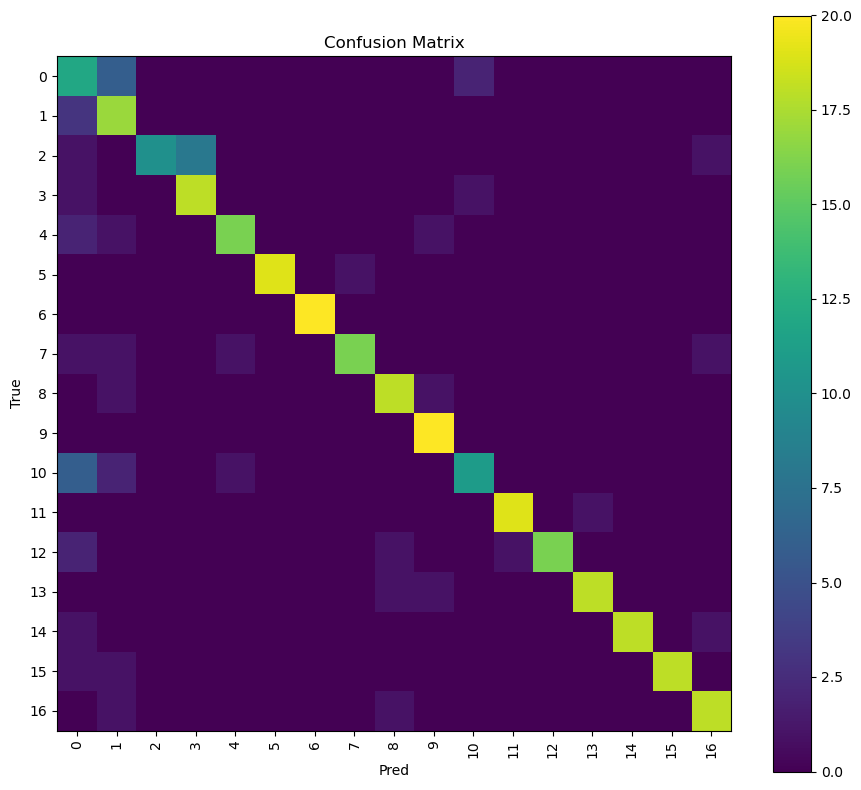

In [23]:
preds = trainer.predict(encoded["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(LABELS))],
    digits=4
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, [i for i in range(len(LABELS))], rotation=90)  
plt.yticks(tick_marks, [i for i in range(len(LABELS))])
plt.tight_layout()
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [24]:
clf = TextClassificationPipeline(
    model=trainer.model,
    tokenizer=tokenizer_cls,
    top_k=None
)

def answer_dialog(dialog_text: str):
    pred = clf(dialog_text, truncation=True, max_length=MAX_LEN)[0]
    if isinstance(pred, list):
        pred = pred[0]
    label = pred["label"] 
    return label, CANNED_ANSWERS.get(label, "[нет ответа]")

idxs = random.sample(range(len(dataset["test"])), 5)

for i in idxs:
    text = dataset["test"][i]["text"]
    true_lbl = id2label[dataset["test"][i]["label"]]
    label_pred, canned = answer_dialog(text)
    print("DIALOG:\n", text)
    print("TRUE:", true_lbl, "| PRED:", label_pred)
    print("CANNED:", canned)
    print("=" * 80)

Device set to use cuda:0


DIALOG:
 user: Здравствуйте, мне нужна помощь с моей картой.
assistant: Конечно, рад помочь. Какую именно информацию вы ищете?
user: Мне интересно, какие категории покупок дают кешбэк или акции.
assistant: О, это важно знать. Обычно они выплачиваются за товары или услуги в определенных категориях. Например, гаджеты, книги, спорт и так далее. А у вас есть конкретная категория, которую вы хотите рассмотреть?
user: Да, вот например, одежда. Может, там какая-то специальная программа?
TRUE: cashback_info | PRED: cashback_info
CANNED: Расскажу о кешбэке и акциях. Напишите категорию покупок и вашу карту.
DIALOG:
 user: Здравствуйте! Мне сегодня пришло сообщение о попытке мошенничества на карте.
assistant: Простите за беспокойство. Позвольте мне уточнить некоторые детали.
user: Перевод был сделан около 17:00. Номер карты заканчивается на 5678.
assistant: Хорошо, сейчас об этом займусь. Как вы думаете, это может быть связано со мной?
user: Может быть? Но я сильно переживаю...
assistant: Спасибо